# Variational Autoencoder (VAE) for Google Colab

In [1]:
import torch
import torch.nn as nn
import torch.distributions as td
import torch.utils.data
from torch.nn import functional as F
from tqdm import tqdm
from torchvision import datasets, transforms
from torchvision.utils import save_image

# I have inserted this to make the plot_posterior function.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

print(f"Using torch version: {torch.__version__}")


Using torch version: 2.5.1+cu124


In [2]:
class GaussianPrior(nn.Module):
    def __init__(self, M):
        super(GaussianPrior, self).__init__()
        self.M = M
        self.mean = nn.Parameter(torch.zeros(self.M), requires_grad=False)
        self.std = nn.Parameter(torch.ones(self.M), requires_grad=False)

    def forward(self):
        return td.Independent(td.Normal(loc=self.mean, scale=self.std), 1)

class GaussianEncoder(nn.Module):
    def __init__(self, encoder_net):
        super(GaussianEncoder, self).__init__()
        self.encoder_net = encoder_net

    def forward(self, x):
        mean, std = torch.chunk(self.encoder_net(x), 2, dim=-1)
        return td.Independent(td.Normal(loc=mean, scale=torch.exp(std)), 1)

class BernoulliDecoder(nn.Module):
    def __init__(self, decoder_net):
        super(BernoulliDecoder, self).__init__()
        self.decoder_net = decoder_net

    def forward(self, z):
        logits = self.decoder_net(z)
        return td.Independent(td.Bernoulli(logits=logits), 2)

class VAE(nn.Module):
    def __init__(self, prior, decoder, encoder):
        super(VAE, self).__init__()
        self.prior = prior
        self.decoder = decoder
        self.encoder = encoder

    def elbo(self, x):
        q = self.encoder(x)
        z = q.rsample()
        # This is the changed elbo.
        # Source: https://github.com/tensorflow/probability/issues/199 and TA.
        prior = self.prior()
        log_qz = q.log_prob(z)
        log_pz = prior.log_prob(z)
        kl_div = log_qz - log_pz  # Estimated KL
        elbo = torch.mean(self.decoder(z).log_prob(x) - kl_div, dim=0)

        return elbo

    def sample(self, n_samples=1):
        z = self.prior().sample(torch.Size([n_samples]))
        return self.decoder(z).sample()

    def forward(self, x):
        return -self.elbo(x)

class MoGPrior(nn.Module):
    def __init__(self, M, num_components):
        super(MoGPrior, self).__init__()
        self.M = M
        self.num_components = num_components

        # How much weight should each distribution have?
        # Source: https://github.com/EugenHotaj/pytorch-generative/blob/master/pytorch_generative/models/mixture_models.py
        self.mixture_logits = nn.Parameter(torch.zeros(num_components))

        # Mu and sigma for each distribution.
        # Source: https://jmtomczak.github.io/blog/7/7_priors.html
        self.means = nn.Parameter(torch.randn(num_components, M))
        self.stds = nn.Parameter(torch.randn(num_components, M).abs())

    def forward(self):
        # Source: https://pytorch.org/docs/stable/distributions.html and TA.
        mixture_distribution = td.Categorical(logits=self.mixture_logits)
        component_distribution = td.Independent(td.Normal(loc=self.means, scale=self.stds), 1)
        return td.MixtureSameFamily(mixture_distribution, component_distribution)

class VampPrior(nn.Module):
    def __init__(self, M, K, image_width, image_height, encoder):
        super(VampPrior, self).__init__()
        self.M = M
        self.K = K
        self.image_width = image_width
        self.image_height = image_height
        self.encoder = encoder

        # Vamprior Pseud-inputs
        self.pseudoinputs = nn.Parameter(torch.rand(K,image_width, image_height))

    def forward(self):
        mean = torch.zeros(self.M, device = self.pseudoinputs.device)
        std = torch.zeros(self.M, device = self.pseudoinputs.device)
        for k in range(self.K):
            q = self.encoder(self.pseudoinputs[k].unsqueeze(dim=0))
            mean += q.mean.squeeze()
            std += q.stddev.squeeze()
        mean /= self.K
        std /= self.K
        return td.Independent(td.Normal(loc=mean, scale=std), 1)


In [3]:
def train(model, optimizer, data_loader, epochs, device):
    model.train()
    total_steps = len(data_loader) * epochs
    # progress_bar = tqdm(range(total_steps), desc="Training")
    batch_loss = []
    for epoch in range(epochs):
        data_iter = iter(data_loader)
        epoch_elbos = []
        for x in data_iter:
            x = x[0].to(device)
            optimizer.zero_grad()
            loss = model(x)
            loss.backward()
            batch_loss.append(loss.item())
            optimizer.step()

            # This is to get the ELBO for each batch.
            elbo_value = model.elbo(x)
            epoch_elbos.append(elbo_value.item())


            # progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}")
            # progress_bar.update()
        print(f"Epoch {epoch+1}, ELBO: {sum(epoch_elbos)/len(epoch_elbos)}")
    return batch_loss


In [6]:
# Here are the parameters.
mode = 'train'  # Choose 'train or' 'sample'.
model_path = 'vae_model.pt'
samples_path = 'vae_samples.png'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
epochs = 10
latent_dim = 32

print(f"Using device: {device}")

# Load MNIST dataset
thresshold = 0.5
mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: (thresshold < x).float().squeeze())
                   ])),
    batch_size=batch_size, shuffle=True)

# Define prior distribution
M = latent_dim
# num_components=5 # I have played with this number.
pseudo_inputs = 50

# Define encoder and decoder networks
encoder_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, M * 2),
)

decoder_net = nn.Sequential(
    nn.Linear(M, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 784),
    nn.Unflatten(-1, (28, 28))
)

# Define VAE model
decoder = BernoulliDecoder(decoder_net)
encoder = GaussianEncoder(encoder_net)
prior = VampPrior(M, pseudo_inputs, 28, 28, encoder)
model = VAE(prior, decoder, encoder).to(device)

if mode == 'train':
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train(model, optimizer, mnist_train_loader, epochs, device)
    torch.save(model.state_dict(), model_path)
    print("Model saved.")
elif mode == 'sample':
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    with torch.no_grad():
        samples = model.sample(64).cpu()
        save_image(samples.view(64, 1, 28, 28), samples_path)
        print(f"Samples saved to {samples_path}.")


Using device: cuda
Epoch 1, ELBO: -139.57653127441407
Epoch 2, ELBO: -107.64491017659505
Epoch 3, ELBO: -100.79782226969401
Epoch 4, ELBO: -96.06216254069011
Epoch 5, ELBO: -93.07107646891276
Epoch 6, ELBO: -91.31319455973308
Epoch 7, ELBO: -90.02634724934896
Epoch 8, ELBO: -89.06623924153646
Epoch 9, ELBO: -88.27908579508464
Epoch 10, ELBO: -87.60571552327474
Model saved.


In [7]:
# This is the plot for the aprroximate posterior.
# Source: https://python-graph-gallery.com/515-intro-pca-graph-python/
# Source: https://matplotlib.org/stable/index.html and TA.
def plot_posterior(model, test_loader, device):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            q = model.encoder(x)
            z = q.rsample()
            latent_vectors.append(z.cpu().numpy())
            labels.append(y.numpy())

    # I guess it is okay to use numpy arrays?
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    # The TA said something about dimensionality reduction.
    M = latent_vectors.shape[1]
    if M > 2:
        pca = PCA(n_components=2)
        latent_vectors_2d = pca.fit_transform(latent_vectors)
    else:
        latent_vectors_2d = latent_vectors

    # Very nice to know matplotlib :-).
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter, label="MNIST Class")
    plt.xlabel("Latent_Dim_1" if M == 2 else "PCA_Comp_1")
    plt.ylabel("Latent_Dim_2" if M == 2 else "PCA_Comp_2")
    plt.title("Samples from the Approximate Posterior")
    plt.show()

# Load MNIST test set
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: (x > 0.5).float().squeeze())
                   ])),
    batch_size=batch_size, shuffle=False
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [8]:
# This is the plot for the aprroximate posterior.
# Source: https://python-graph-gallery.com/515-intro-pca-graph-python/
# Source: https://matplotlib.org/stable/index.html and TA.
def plot_posterior_and_prior(model: VAE, test_loader, device):
    model.eval()
    z_vectors = []
    labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            q = model.encoder(x)
            z = q.rsample()
            z_vectors.append(z.cpu().numpy())
            labels.append(y.numpy())

    # I guess it is okay to use numpy arrays?
    z_vectors = np.concatenate(z_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Calculate the prior
    n_prior = len(z_vectors)
    sample_prior = model.prior().sample((n_prior,)).cpu()

    # The TA said something about dimensionality reduction.
    M = z_vectors.shape[1]
    if M > 2:
        pca = PCA(n_components=2)
        z_vectors_2d = pca.fit_transform(z_vectors)
        sample_prior = pca.transform(sample_prior)
        # Print pca explained variance
        print(f"{sum(pca.explained_variance_ratio_[:2])*100}% explained variance of the PCA")
    else:
        z_vectors_2d = z_vectors

    # Very nice to know matplotlib :-).
    # Plotting both distributions one on top of the other doesn't make sense because they end up being just normal distributions

    # Plot in two side by side figures the approximate posterior and the prior
    fig, axs = plt.subplots(1,2)
    # set figure size
    fig.set_size_inches(16, 8)
    axs[0].scatter(z_vectors_2d[:, 0], z_vectors_2d[:, 1], c=labels, cmap='tab10', alpha=0.5)
    axs[0].set_title("Approximate Posterior")
    axs[0].set_xlabel("Latent_Dim_1" if M == 2 else "PCA_Comp_1")
    axs[0].set_ylabel("Latent_Dim_2" if M == 2 else "PCA_Comp_2")

    axs[1].scatter(sample_prior[:, 0], sample_prior[:, 1], c=labels, cmap='tab10', alpha=0.5)
    axs[1].set_title("Prior")
    axs[1].set_xlabel("Latent_Dim_1" if M == 2 else "PCA_Comp_1")
    axs[1].set_ylabel("Latent_Dim_2" if M == 2 else "PCA_Comp_2")
    fig.savefig("partA_prior_and_posterior.png")
    plt.show()

# Load MNIST test set
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: (x > 0.5).float().squeeze())
                   ])),
    batch_size=batch_size, shuffle=False
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

38.796839118003845% explained variance of the PCA


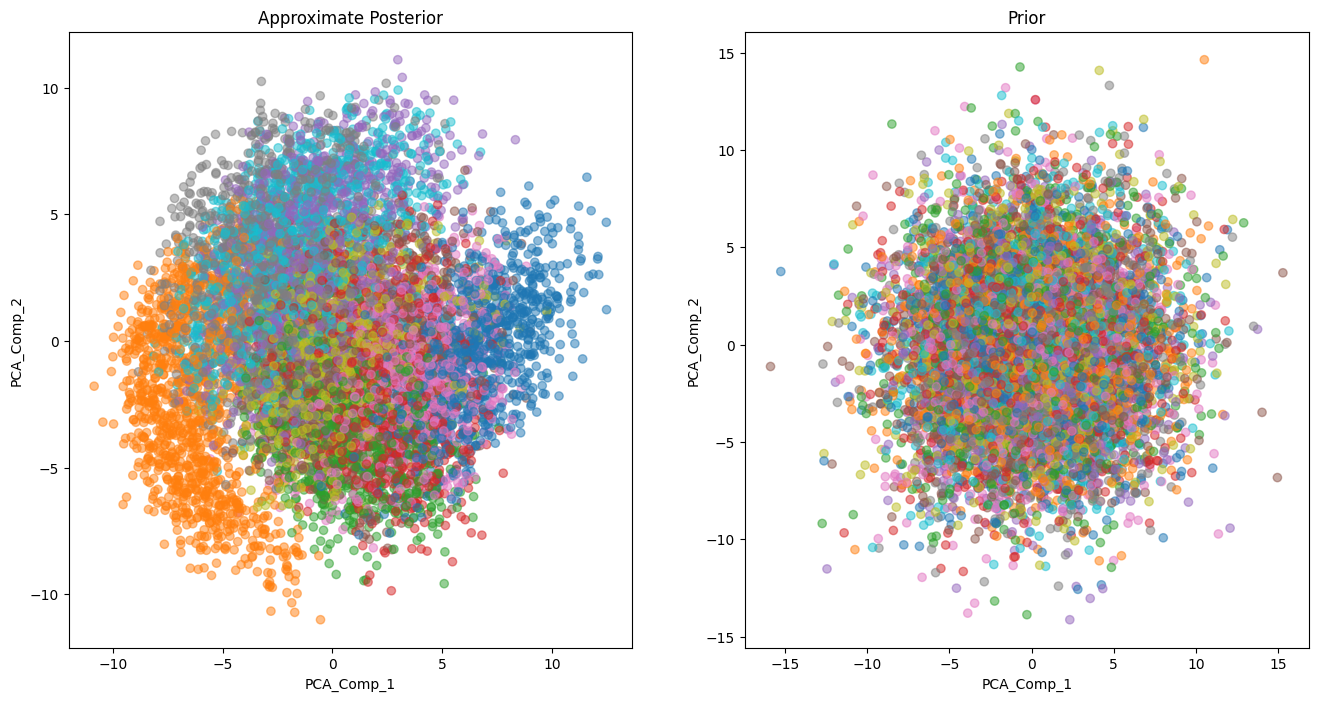

In [9]:
 # This the call to the fuunction to make the plot.
 plot_posterior_and_prior(model, test_loader, device)

In [ ]:
mnist_test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data/', train=False, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Lambda(lambda x: (thresshold < x).float().squeeze())
                    ])),
        batch_size=1, shuffle=True)
def get_test_elbo_values(VAEClass, PriorClass, mnist_test_loader,
                         batch_size=32, epochs = 10, latent_dim = 32,
                         n_training_loops=10, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):


    elbos = [[0 for _ in range(len(mnist_test_loader))] for _ in range(n_training_loops)]
    # Load MNIST dataset
    thresshold = 0.5
    mnist_train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data/', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Lambda(lambda x: (thresshold < x).float().squeeze())
                    ])),
    batch_size=batch_size, shuffle=True)
    loss = []
    for i in range(n_training_loops):
        print(f"Starting training loop {i+1}")
        # Define prior distribution
        M = latent_dim
        num_components=5 # I have played with this number.

        # Define encoder and decoder networks
        encoder_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, M * 2),
        )

        decoder_net = nn.Sequential(
            nn.Linear(M, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Unflatten(-1, (28, 28))
        )

        # Define VAE model
        decoder = BernoulliDecoder(decoder_net)
        encoder = GaussianEncoder(encoder_net)
        prior = PriorClass(M, num_components, 28, 28, encoder)
        model = VAEClass(prior, decoder, encoder).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        batch_loss = train(model, optimizer, mnist_train_loader, epochs, device)
        loss += [batch_loss]
        j = 0
        print("Evaluating ELBO on test dataset")
        for x in mnist_test_loader:
            x = x[0].to(device)
            elbos[i][j] = model.elbo(x).cpu()
            j+=1
    elbos = [[x.item() for x in y] for y in elbos]
    return elbos, loss

In [ ]:
n_training_loops = 5
elbos, batch_loss = get_test_elbo_values(VAE, VampPrior, mnist_test_loader, epochs=20, n_training_loops=n_training_loops)

Epoch 1, ELBO: -138.23635572916666
Epoch 2, ELBO: -105.95599329427084
Epoch 3, ELBO: -99.11338911132812
Epoch 4, ELBO: -95.94847131347656
Epoch 5, ELBO: -94.03212867838542
Epoch 6, ELBO: -92.67373582356771
Epoch 7, ELBO: -91.53447118733725
Epoch 8, ELBO: -90.64598639729817
Epoch 9, ELBO: -89.71575113932292
Epoch 10, ELBO: -88.67116045328775
Epoch 11, ELBO: -87.81545378011067
Epoch 12, ELBO: -87.12426264648437
Epoch 13, ELBO: -86.53955457356771
Epoch 14, ELBO: -86.02234743652343
Epoch 15, ELBO: -85.67903006184896
Epoch 16, ELBO: -85.25734040120443
Epoch 17, ELBO: -84.99158431803386
Epoch 18, ELBO: -84.57090012613932
Epoch 19, ELBO: -84.3474712117513
Epoch 20, ELBO: -84.05576136067708
Epoch 1, ELBO: -140.5288266845703
Epoch 2, ELBO: -106.7139822672526
Epoch 3, ELBO: -99.27130602620443
Epoch 4, ELBO: -95.9420508992513
Epoch 5, ELBO: -93.4225044921875
Epoch 6, ELBO: -91.59649715983073
Epoch 7, ELBO: -90.2512660522461
Epoch 8, ELBO: -89.13642131754557
Epoch 9, ELBO: -88.193451175944
Epoch 1

In [ ]:
elbos = [[x.item() for x in y] for y in elbos]

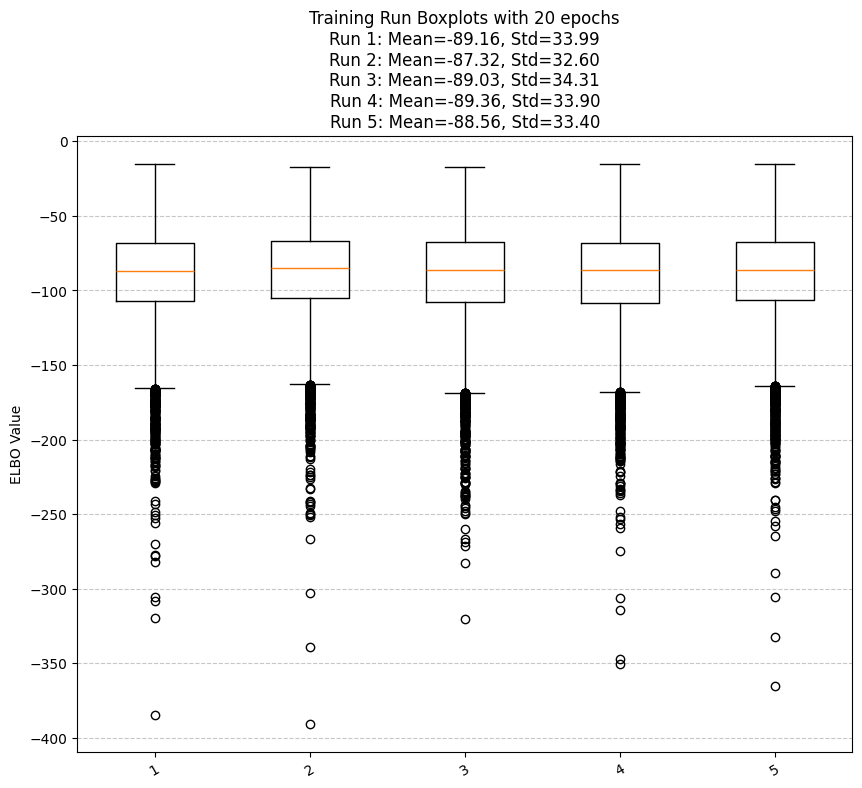

In [ ]:
# Make a box plot for each trainig run, that has the mean and std in the title
run_names = [f"Run {i+1}" for i in range(n_training_loops)]

means = [np.mean(run) for run in elbos]
stds = [np.std(run) for run in elbos]

# Create the box plota
plt.figure(figsize=(10, 8))
plt.boxplot(elbos)

# Add title with mean and std info
title = "Training Run Boxplots with 20 epochs\n" + "\n".join([f"{name}: Mean={mean:.2f}, Std={std:.2f}"
                                                for name, mean, std in zip(run_names, means, stds)])
plt.title(title, fontsize=12)
plt.ylabel("ELBO Value")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_loss_trend(batch_loss, n_training_loops, window_size=50):
    plt.figure(figsize=(10, 8))

    for i in range(n_training_loops):
        smoothed_loss = moving_average(batch_loss[i], window_size)
        plt.plot(smoothed_loss, label=f"Run {i+1}")

    plt.xlabel("Iterations")
    plt.ylabel("Batch Loss")
    plt.title("Smoothed Batch Loss Trend")
    plt.legend()
    plt.show()

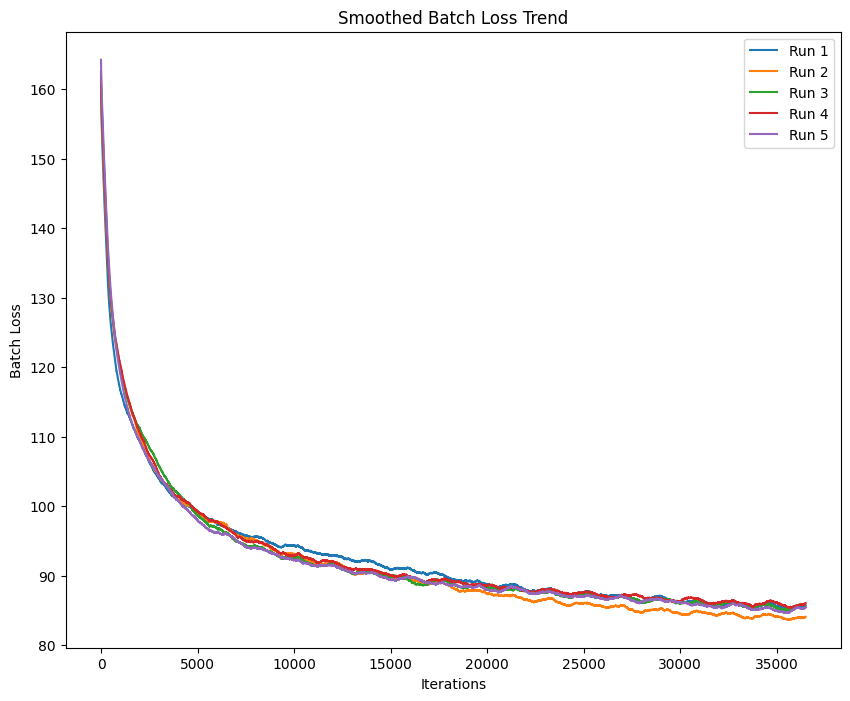

In [ ]:
plot_loss_trend(batch_loss, n_training_loops, window_size=1000)

In [ ]:
flat_elbo = [x for y in elbos for x in y]
# Calculate std
std = np.std(flat_elbo)
# Calculate mean
mean = np.mean(flat_elbo)
print("TOTAL")
print(f"Mean: {mean:.2f}, Std: {std:.2f}")